### Import Libraries:

Import necessary libraries
- pandas, sklearn.preprocessing - (for Data Processing),
- sklearn.naive_bayes, sklearn.linear_model, sklearn.model_selection (for Model Selection),
- sklearn.metrics (For Evaluation),
- matplotlib, seaborn (For Visualization)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Load Reshape and Normalize the Data

#### Load MNIST Data:

- Loads the MNIST dataset from TensorFlow and splits it into training and testing sets.This dataset contains images of handwritten digits.
We are classifying the digits 5 and 2. After splitting, we reshape the data, normalize it.

In [4]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Classify for digits 5 and 2
X_train = X_train[(y_train == 5) | (y_train == 2)]
y_train = y_train[(y_train == 5) | (y_train == 2)]
X_test = X_test[(y_test == 5) | (y_test == 2)]
y_test = y_test[(y_test == 5) | (y_test == 2)]

# Convert to binary classification problem (5 is 1 and 2 is 0 for both train and test)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Reshape and normalize
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

print(X_train.shape, X_test.shape)

(11379, 784) (1924, 784)


#### Standardized the data

In [5]:
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Naive Bayes Model:
- Trains a Naive Bayes model on the training data and makes predictions on the test set. And computes the accuracy of the model.

In [6]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

### Logistic Regression Model:
- Trains a Logistic Regression model on the training data and makes predictions on the test set. Accuracy is also computed.

In [204]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

### Model Performance Output:
- Prints the accuracy of the Naive Bayes and Logistic Regression models
Computes and prints the confusion matrices for both models, showing how many predictions were correct or incorrect for each class.
Also, Outputs detailed classification metrics (precision, recall, f1-score, support) for both models.


In [205]:
print(f'Naive Bayes Accuracy: {acc_nb:.2f}')
print(f'Logistic Regression Accuracy: {acc_lr:.2f}')

Naive Bayes Accuracy: 0.76
Logistic Regression Accuracy: 0.98


In [213]:
# Confusion Matrix
confMatrix_nb = confusion_matrix(y_test, y_pred_nb)
confMatrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Naive Bayes:")
print(confMatrix_nb)
print("Logistic Regression:")
print(confMatrix_lr)

Naive Bayes:
[[592 440]
 [ 21 871]]
Logistic Regression:
[[1012   20]
 [  21  871]]


In [214]:
# Classification Report
classReport_nb = classification_report(y_test, y_pred_nb)
classReport_lr = classification_report(y_test, y_pred_lr)
print("Naive Bayes:")
print(classReport_nb)
print("Logistic Regression:")
print(classReport_lr)

Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      1032
           1       0.66      0.98      0.79       892

    accuracy                           0.76      1924
   macro avg       0.82      0.78      0.76      1924
weighted avg       0.83      0.76      0.75      1924

Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1032
           1       0.98      0.98      0.98       892

    accuracy                           0.98      1924
   macro avg       0.98      0.98      0.98      1924
weighted avg       0.98      0.98      0.98      1924



### ROC Curve and AUC Calculation:

- Calculates and plots the ROC curve and computes the AUC score for both models, which help assess their performance in distinguishing between the two classes.

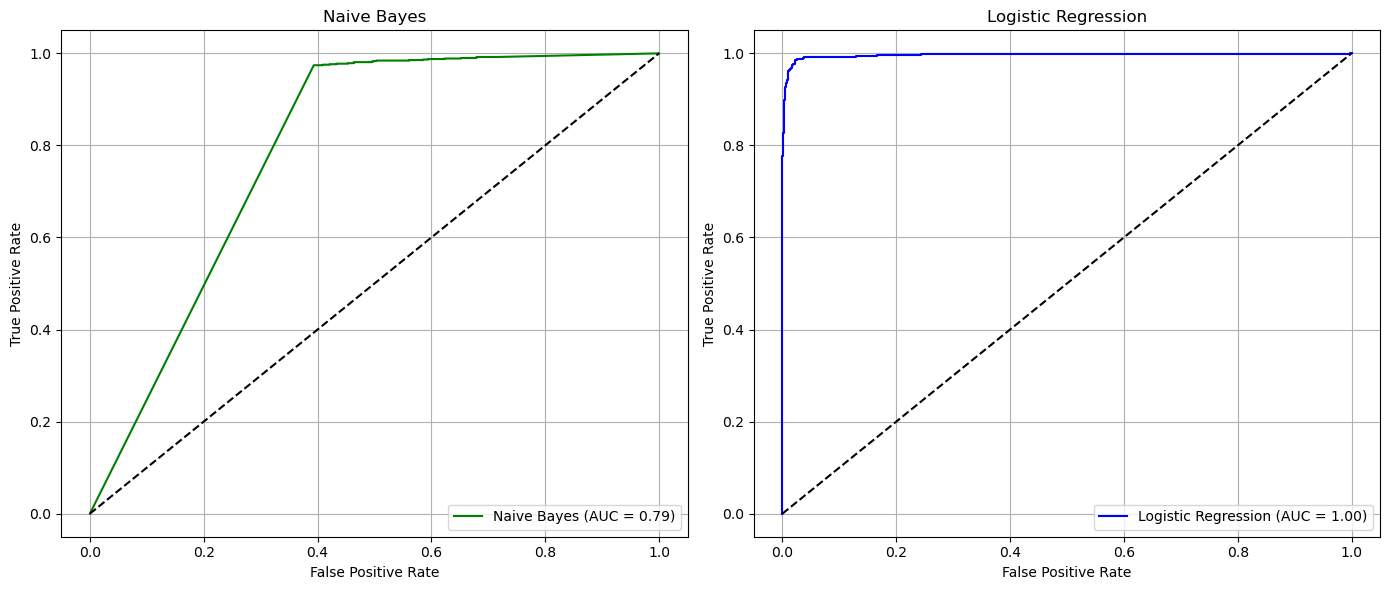

In [225]:
# ROC Curve and AUC
y_prob_nb = nb.predict_proba(X_test)[:, 1]
y_prob_lr = lr.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(fpr_nb, tpr_nb, color = 'green', label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_title("Naive Bayes")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(loc="lower right")
ax[0].grid()

ax[1].plot(fpr_lr, tpr_lr, color = 'blue', label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title("Logistic Regression")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend(loc="lower right")
ax[1].grid()

plt.tight_layout()
plt.show()

### Lift and Gain Calculation Function:

- Defines a custom function to calculate the lift and gain of the models by dividing predictions into deciles and comparing the cumulative positive rate to the total positive rate.

In [238]:
# Lift and Gain function
def lift_gain(y_true, y_prob, num_deciles=10):
    # Convert to DataFrame and sort by probabilities
    df = pd.DataFrame({'Actual': y_true, 'Probability': y_prob}).sort_values('Probability', ascending=False)
    df['Decile'] = pd.qcut(df['Probability'], q=num_deciles, labels=False, duplicates='drop')
    df['Decile'] = num_deciles - df['Decile']
    total_positives = df['Actual'].sum()
    decile, positives, count, cumulative_positives, cumulative_percentage, lift, gain = [], [], [], [], [], [], []
    
    # Group by deciles and calculate values
    grouped = df.groupby('Decile')
    cum_positives = 0
    
    for i, group in grouped:
        decile.append(i)
        pos_in_decile = group['Actual'].sum()
        count.append(len(group))
        
        cum_positives += pos_in_decile
        cumulative_positives.append(cum_positives)
        cumulative_percentage.append(cum_positives / total_positives if total_positives != 0 else 0)
        gain.append(cum_positives / total_positives if total_positives != 0 else 0)
        lift.append((cum_positives / total_positives) / (i / num_deciles) if total_positives != 0 else 0)
        positives.append(pos_in_decile)
    return pd.DataFrame({
        'Decile': decile,
        'Positives': positives, 
        'Count': count,
        'Cumulative Positives': cumulative_positives, 
        'Cumulative Percentage': cumulative_percentage, 
        'Lift': lift, 
        'Gain': gain
    })

### Lift and Gain Output:
- Prints the lift and gain for both Logistic Regression and Naive Bayes models.

In [239]:
lift_gain_lr = lift_gain(y_test, y_prob_lr)
lift_gain_nb = lift_gain(y_test, y_prob_nb)

print("Logistic Regression Lift and Gain:")
print(lift_gain_lr)
print("Naive Bayes Lift and Gain:")
print(lift_gain_nb)


Logistic Regression Lift and Gain:
   Decile  Positives  Count  Cumulative Positives  Cumulative Percentage  \
0       1        193    193                   193               0.216368   
1       2        192    192                   385               0.431614   
2       3        192    192                   577               0.646861   
3       4        190    193                   767               0.859865   
4       5        117    192                   884               0.991031   
5       6          6    192                   890               0.997758   
6       7          1    193                   891               0.998879   
7       8          0    192                   891               0.998879   
8       9          0    192                   891               0.998879   
9      10          1    193                   892               1.000000   

       Lift      Gain  
0  2.163677  0.216368  
1  2.158072  0.431614  
2  2.156203  0.646861  
3  2.149664  0.859865  
4  1.982

#### Plot Lift and Gain Curves:
- Visualizes the lift and gain for both models, plotting them on two separate subplots with dual y-axes to show both metrics in a clear, comparative way.

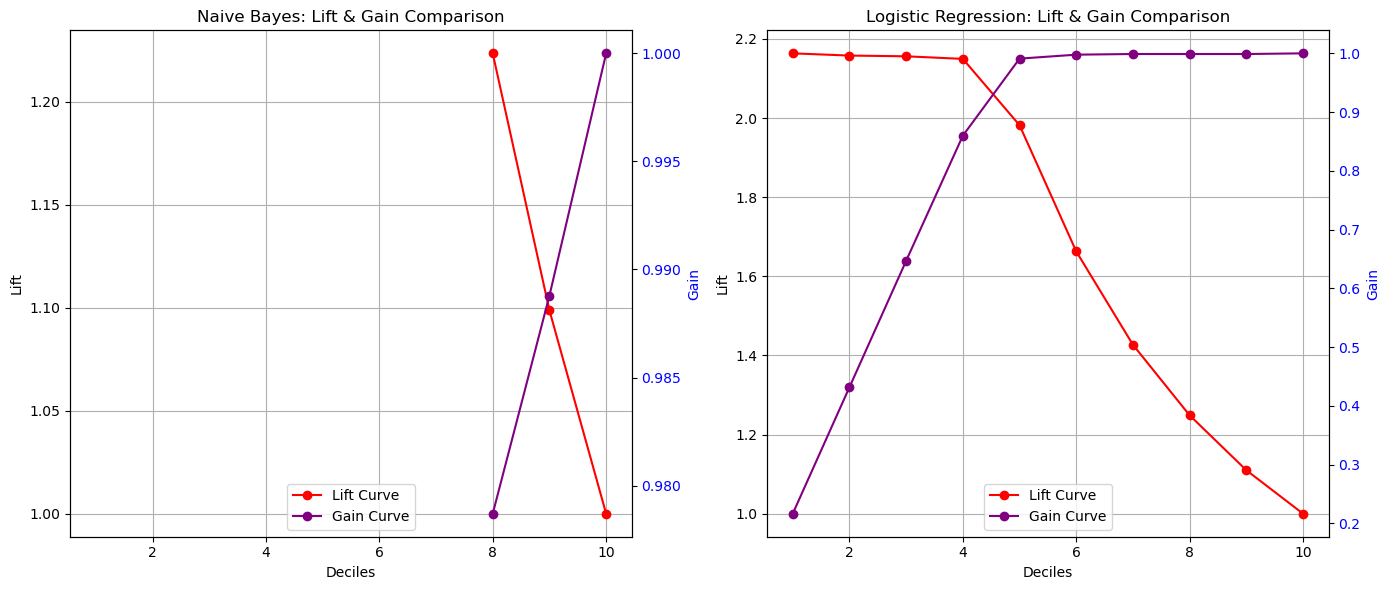

In [250]:
fig, subplots = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Naive Bayes: Plot Lift and Gain on separate y-axes
subplots[0].plot(lift_gain_nb['Decile'], lift_gain_nb['Lift'], label="Lift Curve", marker='o', color='red')
subplots[0].set_title("Naive Bayes: Lift & Gain Comparison")
subplots[0].set_xlabel("Deciles")
subplots[0].set_ylabel("Lift", color='black')
subplots[0].tick_params(axis='y', labelcolor='black')

gain_axis_nb = subplots[0].twinx()
gain_axis_nb.plot(lift_gain_nb['Decile'], lift_gain_nb['Gain'], label="Gain Curve", marker='o', color='purple')
gain_axis_nb.set_ylabel("Gain", color='blue')
gain_axis_nb.tick_params(axis='y', labelcolor='blue')

line_handles_0, line_labels_0 = subplots[0].get_legend_handles_labels()
gain_handles_0, gain_labels_0 = gain_axis_nb.get_legend_handles_labels()
subplots[0].legend(line_handles_0 + gain_handles_0, line_labels_0 + gain_labels_0, loc='lower center')
subplots[0].grid()

# Logistic Regression: Plot Lift and Gain on separate y-axes
subplots[1].plot(lift_gain_lr['Decile'], lift_gain_lr['Lift'], label="Lift Curve", marker='o', color='red')
subplots[1].set_title("Logistic Regression: Lift & Gain Comparison")
subplots[1].set_xlabel("Deciles")
subplots[1].set_ylabel("Lift", color='black')
subplots[1].tick_params(axis='y', labelcolor='black')

gain_axis_lr = subplots[1].twinx()
gain_axis_lr.plot(lift_gain_lr['Decile'], lift_gain_lr['Gain'], label="Gain Curve", marker='o', color='purple')
gain_axis_lr.set_ylabel("Gain", color='blue')
gain_axis_lr.tick_params(axis='y', labelcolor='blue')

line_handles_1, line_labels_1 = subplots[1].get_legend_handles_labels()
gain_handles_1, gain_labels_1 = gain_axis_lr.get_legend_handles_labels()
subplots[1].legend(line_handles_1 + gain_handles_1, line_labels_1 + gain_labels_1, loc="lower center")
subplots[1].grid()


plt.tight_layout()
plt.show()
